In [61]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [62]:
from os import listdir, path
from pathlib import Path
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data.datapipes.utils.decoder import imagehandler
from torchdata import datapipes
from torchvision import transforms

BLACK_PIECES = ['p', 'b', 'k', 'r', 'n', 'q']
WHITE_PIECES = [x.upper() for x in BLACK_PIECES]
PIECE_ENCODING = {
    piece: i for (i, piece) in enumerate([np.nan] + BLACK_PIECES + WHITE_PIECES)
}

class ChessDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size = 128):
        super().__init__()
        self.path = path
        self.img_transforms = transforms.Compose([
            # transforms.Grayscale(),
            transforms.ToTensor(),
        ])
        self.batch_size = batch_size


    def setup(self, stage) -> None:
        train_path = path.join(self.path, 'train')
        train_size = len(listdir(train_path))
        
        pipe = datapipes.iter.FileLister(train_path)
        pipe = datapipes.iter.Enumerator(pipe)
        pipe = datapipes.map.IterToMapConverter(pipe)

        val_size = len(pipe) // 4
        train_size = len(pipe) - val_size
        train_pipe, val_pipe = random_split(pipe, [train_size, val_size])
        
        train_pipe = datapipes.iter.IterableWrapper(train_pipe)
        train_pipe = datapipes.iter.FileOpener(train_pipe, 'b', length=train_size)
        train_pipe = datapipes.iter.RoutedDecoder(train_pipe, imagehandler('pil'))
        train_pipe = datapipes.iter.Mapper(train_pipe, self.transforms)
        self.train_pipe = train_pipe

        val_pipe = datapipes.iter.IterableWrapper(val_pipe)
        val_pipe = datapipes.iter.FileOpener(val_pipe, 'b', length=val_size)
        val_pipe = datapipes.iter.RoutedDecoder(val_pipe, imagehandler('pil'))
        val_pipe = datapipes.iter.Mapper(val_pipe, self.transforms)
        self.val_pipe = val_pipe

        test_pipe = datapipes.iter.FileLister(path.join(self.path, 'test'))
        test_pipe = datapipes.iter.FileOpener(test_pipe, 'b')
        test_pipe = datapipes.iter.RoutedDecoder(test_pipe, imagehandler('pil'))
        test_pipe = datapipes.iter.Mapper(test_pipe, self.transforms)
        self.test_pipe = test_pipe

    def parse_fen(self, fen: str):
        def parseRow(fenRow: str):
            row = []
            for char in fenRow:
                if char.isdigit():
                    row += [PIECE_ENCODING[np.nan]] * int(char)
                else:
                    row.append(PIECE_ENCODING[char])
            return row

        board = [parseRow(row) for row in fen.split('-')]
        return torch.tensor(board)

    def transforms(self, data):
        path, img = data
        fen = Path(path).stem
        board = self.parse_fen(fen)
        img = self.img_transforms(img)
        
        return img, board

    def train_dataloader(self):
        return DataLoader(self.train_pipe, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.val_pipe, batch_size=self.batch_size, num_workers=6)

    def test_dataloader(self):
        return DataLoader(self.test_pipe, batch_size=self.batch_size, num_workers=6)

    def predict_dataloader(self):
        return DataLoader(self.test_pipe, batch_size=self.batch_size, num_workers=12)




In [63]:
import pytorch_lightning as pl
from torch import nn, optim

# NOTES
# Image: 400x400x3
# 8x8 Grid
#   => 50x50 cells
# 13 Classes (White/Black King/Queen/Rook/Bishop/Knight/Pawn + Blank Space)
class ChessCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn_1 = nn.Conv2d(3, 5, (5, 5), 5) # Output: 5x80x80 (cells: 5x10x10)
        self.cnn_2 = nn.Conv2d(5, 8, (2, 2), 2) # Output: 8x40x40 (cells: 8x5x5)
        self.pool_1 = nn.MaxPool2d((5, 5), 5) # Output: 8x8x8 (cells: 8x1x1)
        self.cnn_3 = nn.Conv2d(8, 13, (1, 1)) # Output: 12x8x8 (cells: 13x1x1)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, X):
        X = self.cnn_1(X)
        X = self.cnn_2(X)
        X = self.pool_1(X)
        X = self.cnn_3(X)
        return X

    def training_step(self, batch, batch_idx):
        X, y = batch
        scores = self(X)
        loss = self.criterion(scores, y)
        self.log('tr_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        scores = self(X)
        loss = self.criterion(scores, y)
        
        pred = self.predict_step(batch)
        acc = (y == pred).float().mean()
        self.log_dict({
            'val_loss': loss,
            'val_acc': acc,
        })

    def test_step(self, batch, batch_idx):
        X, y = batch
        scores = self(X)
        loss = self.criterion(scores, y)
        
        pred = self.predict_step(batch)
        acc = (y == pred).float().mean()
        self.log_dict({
            'test_loss': loss,
            'test_acc': acc,
        })

    def predict_step(self, batch, batch_idx: int = None, dataloader_idx: int = 0):
        X, y = batch
        scores = self(X)
        return scores.argmax(dim=1)


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=.02)

In [64]:
model = ChessCNN().load_from_checkpoint('../../tb_logs/chess-cnn/version_3/checkpoints/epoch=11-step=5628.ckpt')

In [65]:
data = ChessDataModule('../../data/raw')
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
)
preds = trainer.predict(model, datamodule=data)

/home/nickthegroot/.cache/pypoetry/virtualenvs/cogs118a-group051-tIQIu8CD-py3.10/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nickthegroot/.cache/pypoetry/virtualenvs/cogs118a-group051-tIQIu8CD-py3.10/lib/python3.10/site-packages/torchdata/datapipes/map/util/utils.py:77: UserWarning: Data from prior DataPipe are loaded to get length ofIterToMapConverter before execution of the pipeline.Please consider removing len().
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: : 1884it [03:30,  8.94it/s]


In [66]:
full_preds = torch.cat(preds)
full_label = torch.cat([x[1] for x in iter(data.predict_dataloader())])

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

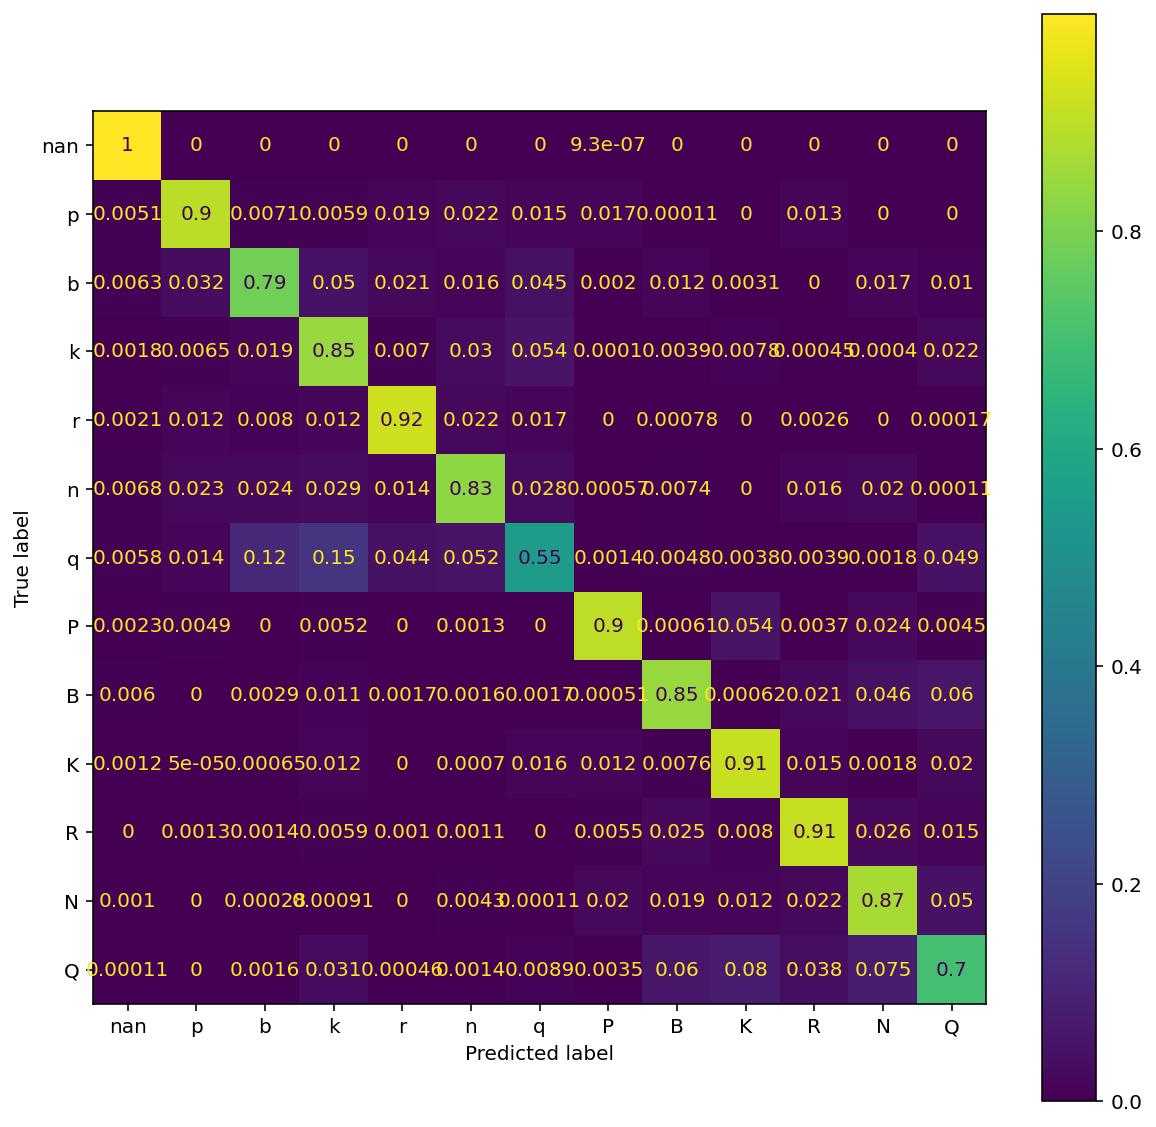

In [68]:
ConfusionMatrixDisplay.from_predictions(full_label.flatten(), full_preds.flatten(), normalize='true', display_labels = PIECE_ENCODING.keys())